In [1]:
initial_path = 'peptide-QML/'
# initial_path = '../'

In [2]:
day = "0809"
name_notebook = day + "-sh_e_1qm.ipynb"

#ask the user if that is correct, if he says yes kkep going, otherwise stop
import sys
answer = input("{} is the name of the notebook | Is that correct? (y/n): ".format(name_notebook))
if answer != "y":
    print("Please, change the name of the notebook")
    sys.exit()

In [3]:
import numpy as np

In [4]:
import sys
sys.path.append(initial_path)

%load_ext autoreload
%autoreload 2
from my_code import functions as f
from my_code import pytorch_model as ptm
from my_code import quantum_nodes as qn
from my_code import pytorch_wrappers as pw

# Data

In [5]:
data_file_path = initial_path + 'data/Scores/PET/generated/bb14_Strings_Energies_10_000_4_aa.txt'  # Replace with the actual path to your 'data.txt' file
string_list, number_list = f.read_data_file(data_file_path)
score_list = np.array(number_list)/1000
vector_list = np.array([f.string_to_numbers(string) for string in string_list]) # one hot encoding

In [6]:
X, Y, X_validation, Y_validation = f.create_validating_set(vector_list, score_list, percentage=0.1)

In [7]:
# Define the dataset
input_data = ptm.torch.tensor(X) 
target_data = ptm.torch.tensor(Y).view(-1, 1)

# Define the validation set
input_validation = ptm.torch.tensor(X_validation)
target_validation = ptm.torch.tensor(Y_validation).view(-1, 1)

In [8]:
input_data.shape, target_data.shape, input_validation.shape, target_validation.shape

(torch.Size([9000, 4]),
 torch.Size([9000, 1]),
 torch.Size([1000, 4]),
 torch.Size([1000, 1]))

# Quantum node

In [9]:
n_aminoacids = len(string_list[0])

In [10]:
quantum_layer = qn.circuit(
    n_qubits = n_aminoacids, 
    device = "default.qubit.torch",
    device_options = {'shots': None},
    embedding = qn.parts.AngleEmbedding, 
    # embedding_ansatz = qn.parts.Ansatz_11,
    block_ansatz = qn.parts.Ansatz_11,
    measurement = qn.parts.Measurement('Z', 1),
    # embedding_n_layers = 4,
    # different_inputs_per_layer = False,
    block_n_layers = 50,
    # wrapper_qlayer = pw.QLayer,
    wrapper_qlayer = None,
)

In [11]:
quantum_layer.weights_shape, quantum_layer.input_shape

({'block_weights': (600,)}, (4,))

/usr/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: 
The examples.directory rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2. In the future, examples will be found relative to the 'datapath' directory.
  self[key] = other[key]
/usr/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]
/usr/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
  self[key] = other[key]
/usr/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: 
The verbose.fileo rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]
/usr/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: 
The verbose.level rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  

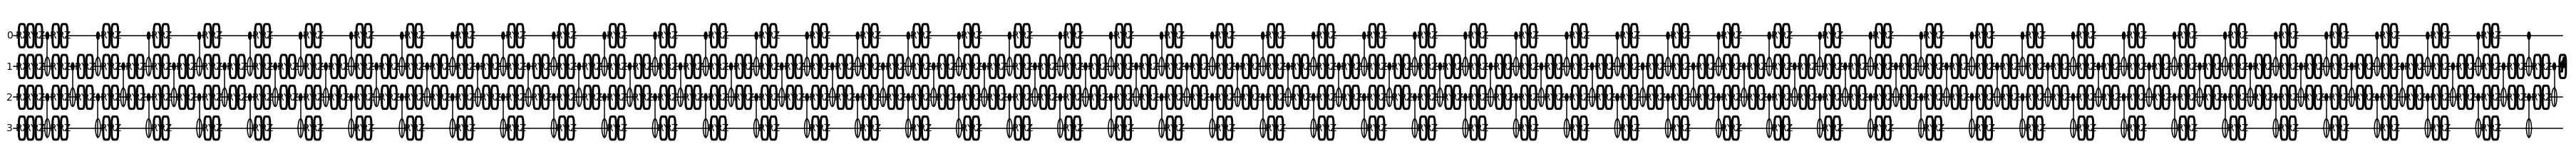

In [12]:
quantum_layer.draw(size=(50,3))

# Hybrid model

In [13]:
input_dim = input_data.size(1)

n_pre_classical_layers = 4
layers_dim = np.linspace(n_aminoacids, input_dim, 4).astype(int)

In [14]:
import torch.nn as nn
import torch
class ClippedReLU(nn.Module):
    def __init__(self, clip_val=1):
        super(ClippedReLU, self).__init__()
        self.clip_val = clip_val

    def forward(self, x):
        return torch.clamp(x, 0, self.clip_val)
    
class Reshape(nn.Module):
    def __init__(self):
        super(Reshape, self).__init__()

    def forward(self, x):
        dims = len(x.shape)
        return torch.transpose(x, dims-2, dims-1).reshape(x.shape[-3] if dims==3 else 1, x.shape[-2]*x.shape[-1]).squeeze()

In [15]:
layers =  [ptm.nn.Embedding(num_embeddings=19, embedding_dim=quantum_layer.input_shape[0]//n_aminoacids), Reshape()]
layers += [quantum_layer()]


In [16]:
# layers = []
# for i in range(1, len(layers_dim)):
#     layers += [ptm.nn.Linear(layers_dim[-1*i], layers_dim[-1*(i+1)]), ptm.nn.ReLU()]
# layers += [ptm.nn.Linear(layers_dim[0], layers_dim[0]), ClippedReLU()]
# layers += [quantum_layer()]
# # layers += [nn.Linear(1, 1)]
# # layers += [nn.Linear(2, 4), nn.ReLU()]
# # layers += [nn.Linear(4, 1)]

In [17]:
# Create model and set data:
model = ptm.pytorch_model(
    layers,    
    save_options = {'initial_path': initial_path, 'name_notebook': name_notebook},
)
model.set_data(
    data_X=input_data, 
    data_Y=target_data, 
    data_X_validation=input_validation,
    data_Y_validation=target_validation
)

In [18]:
x = model.model[0](input_data[0:2])
print(x, x.shape)

x = model.model[1](x)
print(x, x.shape)

x = model.model[2](x)
print(x)

tensor([[[-0.1427],
         [-0.1178],
         [ 1.4030],
         [ 0.8262]],

        [[-0.2626],
         [-0.9759],
         [-1.0906],
         [ 1.4030]]], grad_fn=<EmbeddingBackward>) torch.Size([2, 4, 1])
tensor([[-0.1427, -0.1178,  1.4030,  0.8262],
        [-0.2626, -0.9759, -1.0906,  1.4030]], grad_fn=<SqueezeBackward0>) torch.Size([2, 4])
tensor([[0.1724],
        [0.5419]], grad_fn=<ViewBackward>)


In [19]:
for i in range(2):
    x = model.model[0](input_data[i])
    print(x, x.shape)

    x = model.model[1](x)
    print(x, x.shape)

    x = model.model[2](x)
    print(i, x)

tensor([[-0.1427],
        [-0.1178],
        [ 1.4030],
        [ 0.8262]], grad_fn=<EmbeddingBackward>) torch.Size([4, 1])
tensor([-0.1427, -0.1178,  1.4030,  0.8262], grad_fn=<SqueezeBackward0>) torch.Size([4])
0 tensor([0.1724], grad_fn=<CatBackward>)
tensor([[-0.2626],
        [-0.9759],
        [-1.0906],
        [ 1.4030]], grad_fn=<EmbeddingBackward>) torch.Size([4, 1])
tensor([-0.2626, -0.9759, -1.0906,  1.4030], grad_fn=<SqueezeBackward0>) torch.Size([4])
1 tensor([0.5419], grad_fn=<CatBackward>)


In [20]:
print(model(input_data[0:2]))
print(model(input_data[1]))

tensor([[0.1724],
        [0.5419]], grad_fn=<ViewBackward>)
tensor([0.5419], grad_fn=<CatBackward>)


In [21]:
model.keep_track_params=True,

In [22]:
import torch.optim as optim

# ask the user if he wants to start the training
out = input("Do you want to start the training? (y/n) ")
if out != 'y':
    sys.exit()

# train the model
model.train(
    optimizer= optim.Adam,
    optimizer_options={'lr': 0.05},
    num_epochs = 50,                
    batch_size = 32,
)

Epoch [0/50], Loss: 2.1546, Loss validation: 2.3195


/usr/lib/python3/dist-packages/torch/autograd/__init__.py:147: UserWarning: CUDA initialization: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set an error? Error 804: forward compatibility was attempted on non supported HW (Triggered internally at  ../c10/cuda/CUDAFunctions.cpp:115.)
  Variable._execution_engine.run_backward(


	 Validation string, 	 i: 0; 	 prediction: -0.3795, 	 target: -0.0452, 	 loss: 7.3993
	 Validation string, 	 i: 1; 	 prediction: 0.2067, 	 target: 0.1771, 	 loss: 0.1673
	 Validation string, 	 i: 2; 	 prediction: 0.0453, 	 target: 0.1785, 	 loss: 0.7463
Epoch [1/50], Loss: 1.8486, Loss validation: 2.0567, Time remaining: ~1.0h 28.0m 28s
	 Validation string, 	 i: 0; 	 prediction: 0.3009, 	 target: -0.0452, 	 loss: 7.6589
	 Validation string, 	 i: 1; 	 prediction: -0.1199, 	 target: 0.1771, 	 loss: 1.6771
	 Validation string, 	 i: 2; 	 prediction: -0.0701, 	 target: 0.1785, 	 loss: 1.3926
Epoch [2/50], Loss: 1.7586, Loss validation: 2.0570, Time remaining: ~1.0h 26.0m 46s
	 Validation string, 	 i: 0; 	 prediction: -0.0507, 	 target: -0.0452, 	 loss: 0.1224
	 Validation string, 	 i: 1; 	 prediction: 0.3476, 	 target: 0.1771, 	 loss: 0.9626
	 Validation string, 	 i: 2; 	 prediction: 0.2509, 	 target: 0.1785, 	 loss: 0.4053
Epoch [3/50], Loss: 1.7214, Loss validation: 1.4094, Time remaining

In [23]:
# save string of the model
model.save_str(
    metadata={
        "data_file_path": data_file_path,
    }
)

Saved in:  peptide-QML/checkpoints/0809/txts/0809-sh_e_1qm_model_str_3.txt


Saved in:  peptide-QML/checkpoints/0809/plots/0809-sh_e_1qm_losses_batches_3.png


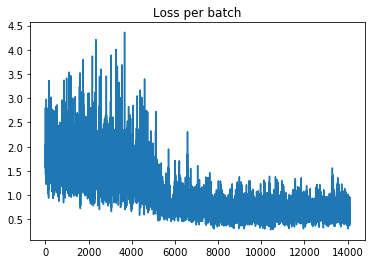

Saved in:  peptide-QML/checkpoints/0809/plots/0809-sh_e_1qm_losses_epoch_3.png


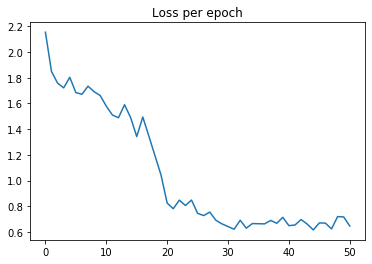

Saved in:  peptide-QML/checkpoints/0809/plots/0809-sh_e_1qm_losses_epoch_validation_3.png


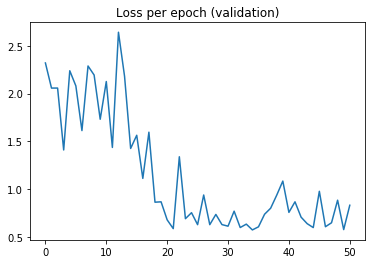

In [25]:
# plot the losses of the trainig loop and save the figures
model.plot_losses(save=True)

Saved in:  peptide-QML/checkpoints/0809/plots/0809-sh_e_1qm_parameter_0.weight_None_3.png


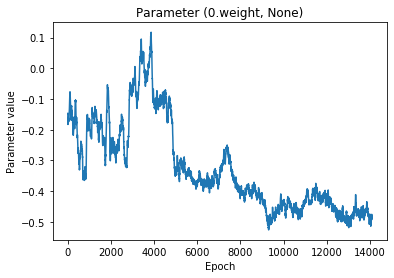

Saved in:  peptide-QML/checkpoints/0809/plots/0809-sh_e_1qm_parameter_2.block_weights_None_3.png


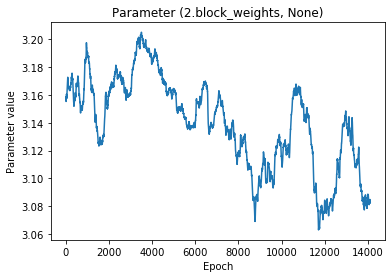

In [26]:
# plot how the average of the parameters in each layer changes over time, and save that
for layer in model.model.state_dict().keys():
    model.plot_parameter(layer=layer, save=True)

In [27]:
# model.plot_parameter(layer='7.weights', index=50)

In [28]:
#save all the parameters of the model and the intermediate parameters of the model
model.save_state_dict(intermediate=False)

Model saved as peptide-QML/checkpoints/0809/models/0809-sh_e_1qm_3.pth


In [29]:
# print validation and save it
model.print_validation(save=True, precision=4, percentatge=1)

i: 0, 		 target: -0.0452, 	 output: 0.0945, 	 loss: 3.0912
i: 1, 		 target: -0.0559, 	 output: 0.1306, 	 loss: 3.3350
i: 2, 		 target: 0.0430, 	 output: 0.3130, 	 loss: 6.2709
i: 3, 		 target: -0.0277, 	 output: 0.1193, 	 loss: 5.3052
i: 4, 		 target: 0.2232, 	 output: 0.2898, 	 loss: 0.2981
i: 5, 		 target: -0.0573, 	 output: 0.0537, 	 loss: 1.9359
i: 6, 		 target: 0.1384, 	 output: 0.1311, 	 loss: 0.0527
i: 7, 		 target: 0.1190, 	 output: 0.1703, 	 loss: 0.4318
i: 8, 		 target: 0.1735, 	 output: 0.0119, 	 loss: 0.9314
i: 9, 		 target: -0.0484, 	 output: 0.0448, 	 loss: 1.9254
i: 10, 		 target: 0.1771, 	 output: 0.2198, 	 loss: 0.2409
i: 11, 		 target: 0.3934, 	 output: 0.1268, 	 loss: 0.6776
i: 12, 		 target: 0.1829, 	 output: 0.2747, 	 loss: 0.5014
i: 13, 		 target: 0.1262, 	 output: 0.1736, 	 loss: 0.3764
i: 14, 		 target: -0.0687, 	 output: 0.0196, 	 loss: 1.2859
i: 15, 		 target: -0.0415, 	 output: -0.0780, 	 loss: 0.8794
i: 16, 		 target: 0.1364, 	 output: 0.0972, 	 loss: 0.2871

In [30]:
# push changes to git
if initial_path != '../':
    !cd peptide-QML && git add . && git commit -m "data trained model" && git push

[main ce936269] data trained model
 21 files changed, 1080 insertions(+), 1 deletion(-)
 create mode 100644 checkpoints/0809/models/0809-sh_e_1qm_3.pth
 create mode 100644 checkpoints/0809/models/0809-sh_e_1qm_v2_1.pth
 create mode 100644 checkpoints/0809/plots/0809-sh_e_1qm_losses_batches_3.png
 create mode 100644 checkpoints/0809/plots/0809-sh_e_1qm_losses_epoch_3.png
 create mode 100644 checkpoints/0809/plots/0809-sh_e_1qm_losses_epoch_validation_3.png
 create mode 100644 checkpoints/0809/plots/0809-sh_e_1qm_parameter_0.weight_None_3.png
 create mode 100644 checkpoints/0809/plots/0809-sh_e_1qm_parameter_2.block_weights_None_3.png
 create mode 100644 checkpoints/0809/plots/0809-sh_e_1qm_v2_losses_batches_1.png
 create mode 100644 checkpoints/0809/plots/0809-sh_e_1qm_v2_losses_epoch_1.png
 create mode 100644 checkpoints/0809/plots/0809-sh_e_1qm_v2_losses_epoch_validation_1.png
 create mode 100644 checkpoints/0809/plots/0809-sh_e_1qm_v2_parameter_0.weight_None_1.png
 create mode 100644